In [1]:
!pip install monai
!pip3 install nibabel
!pip3 install torch
!pip3 install sklearn
!pip3 install tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your depende

In [2]:
import os
import shutil
import matplotlib.pyplot as plt
import PIL
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism
import os
import nibabel as nib
from sklearn.model_selection import train_test_split
from monai.config import print_config
from monai.inferers import SliceInferer
from monai.networks.nets import UNet
from tqdm import tqdm
from monai.transforms import LoadImage, LoadImaged, Resized, Compose, SaveImage
#print_config()

2024-12-03 18:05:34.920247: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 18:05:34.931011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733245534.944353  530423 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733245534.948314  530423 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 18:05:34.962560: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
#T1 dataset :https://brain-development.org/ixi-dataset/
# Define your NIfTI image directory
image_dir = "/home/sayadkouhs/Desktop/dataset/IXI-T1"
print(image_dir)


/home/sayadkouhs/Desktop/dataset/IXI-T1


In [4]:
# Load each image separately and store it in a list
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.nii.gz')]
print(f"Total NIfTI files found: {len(image_paths)}")
images = []
for path in image_paths:
    img = LoadImage(image_only=True, reader="NibabelReader", squeeze_non_spatial_dims=True)(path)
    images.append(img)
#nibabelreader used for the .nii.gz images.

Total NIfTI files found: 581


In [46]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import torch
from monai.transforms import LoadImage, EnsureChannelFirst, Compose, ToTensor
from monai.networks.nets import UNet
from monai.inferers import SliceInferer
import numpy as np
import sys
print(sys.version, sys.platform, sys.executable)
from tqdm import tqdm


# Load a 3D image (NIfTI file) and convert it to a PyTorch tensor
image_path = image_paths[0]  # Use the first image for demonstration
transform = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ToTensor()])
input_volume = transform(image_path)  # Shape: (1, D, H, W)

# Ensure the input volume has the shape (N, C, D, H, W)
input_volume = input_volume.unsqueeze(0)  # Add batch dimension, shape: (1, 1, D, H, W)

# Define a 2D U-Net with randomly initialized weights for testing purposes
net = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(4, 8, 16),
    strides=(2, 2),
    num_res_units=2,
)

# Perform inference along the axial plane (D axis)
axial_inferer = SliceInferer(roi_size=(256, 256), sw_batch_size=1, cval=-1, progress=True)

# Infer along axial slices
axial_output = axial_inferer(input_volume, net)  # Output shape: (N, C, D, H, W)

print("Axial Inferer Output Shape: ", axial_output.shape)

# Perform inference along the coronal plane (H axis)
coronal_inferer = SliceInferer(
    roi_size=(64, 256),  # ROI size for slicing along the H axis
    sw_batch_size=1,
    spatial_dim=1,  # Slice along H axis
    cval=-1,
    progress=True,
)

# Infer along coronal slices
coronal_output = coronal_inferer(input_volume, net)  # Output shape: (N, C, D, H, W)

print("Coronal Inferer Output Shape: ", coronal_output.shape)


3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] linux /bin/python3


100%|██████████| 256/256 [00:02<00:00, 112.87it/s]


Axial Inferer Output Shape:  torch.Size([1, 1, 256, 256, 150])


100%|██████████| 1280/1280 [00:03<00:00, 334.89it/s]

Coronal Inferer Output Shape:  torch.Size([1, 1, 256, 256, 150])


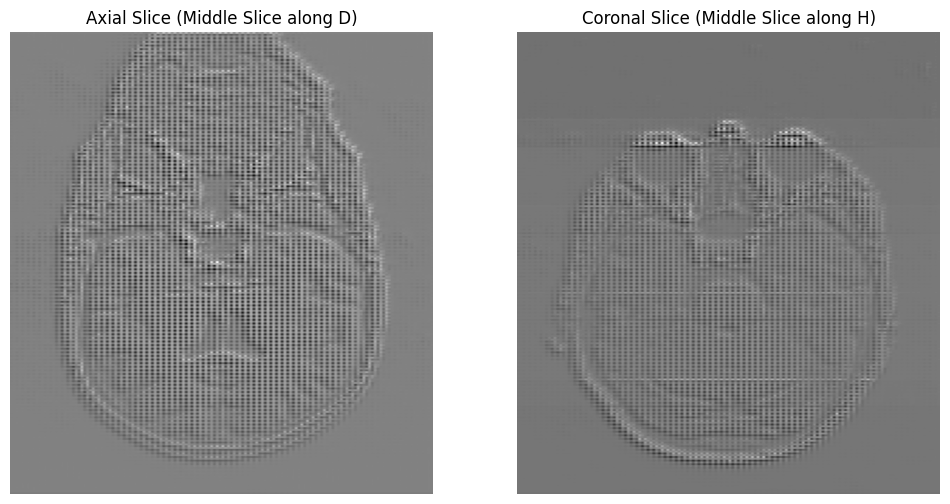

In [22]:

# Normalize and extract the middle slice
axial_middle_slice_index = axial_output.shape[2] // 2  # Middle slice along the D axis
coronal_middle_slice_index = coronal_output.shape[3] // 2  # Middle slice along the H axis

# Extract and normalize the slices
axial_slice = axial_output[0, 0, axial_middle_slice_index, :, :].cpu().detach().numpy()
coronal_slice = coronal_output[0, 0, :, coronal_middle_slice_index, :].cpu().detach().numpy()

# Normalize the slices to [0, 1] for better visualization
axial_slice = (axial_slice - np.min(axial_slice)) / (np.max(axial_slice) - np.min(axial_slice))
coronal_slice = (coronal_slice - np.min(coronal_slice)) / (np.max(coronal_slice) - np.min(coronal_slice))


# Plot both axial and coronal slices
plt.figure(figsize=(12, 6))

# Plot the axial slice
plt.subplot(1, 2, 1)
plt.imshow(axial_slice,cmap='gray', aspect='auto')
plt.title("Axial Slice (Middle Slice along D)")
plt.axis('off')

# Plot the coronal slice
plt.subplot(1, 2, 2)
plt.imshow(coronal_slice, cmap='gray', aspect='auto')
plt.title("Coronal Slice (Middle Slice along H)")
plt.axis('off')

plt.show()